In [3]:
# libraries

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

import matplotlib

# specify GPU
device = torch.device("cuda")
print(device)

cuda


# 下载数据 fetch the data

In [12]:
from datasets import load_dataset
imdb = load_dataset("imdb")

Reusing dataset imdb (C:\Users\iven2\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
print(imdb.shape)
print(imdb['train'][0].keys(), imdb['unsupervised'][0].keys())
imdb['unsupervised'][0:2]['label']

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}
dict_keys(['text', 'label']) dict_keys(['text', 'label'])


[-1, -1]

In [14]:
# turn the data into csv files

df = pd.concat([pd.DataFrame.from_dict(imdb['train']),
                pd.DataFrame.from_dict(imdb['test'])], axis=0)
print(df.shape, df.label.sum())
df.head(10)

(50000, 2) 25000


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
5,I would put this at the top of my list of film...,0
6,Whoever wrote the screenplay for this movie ob...,0
7,"When I first saw a glimpse of this movie, I qu...",0
8,"Who are these ""They""- the actors? the filmmake...",0
9,This is said to be a personal film for Peter B...,0


In [15]:
df = df.sample(5000)
print(df.label.sum())

2514


In [16]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2166, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2166, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [5]:
# import bert-based pretrained model

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
# vocab_size=30522, model_max_len=512
print(tokenizer) 

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [50]:
try_text = [
    'this is a pretrained model and we use it now',
    'who are u?',
    '[UNK]',
    '试一下中文'
]
try_text_id = tokenizer.batch_encode_plus(try_text, padding = True)
print(try_text_id)

# integers 101, 102, ... are special tokens

{'input_ids': [[101, 2023, 2003, 1037, 3653, 23654, 2098, 2944, 1998, 2057, 2224, 2009, 2085, 102], [101, 2040, 2024, 1057, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0], [101, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 100, 1740, 1743, 1746, 1861, 102, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}


[216, 62, 106, 167, 76, 430, 441, 361, 182, 481, 487, 164, 124, 77, 147, 154, 157, 773, 134, 285]


<AxesSubplot:>

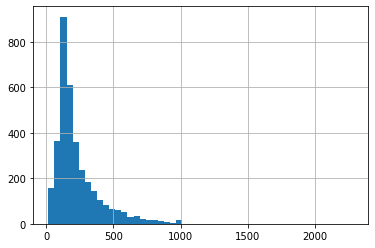

In [233]:
# compare the dataset text-length
seq_len = [len(i.split()) for i in train_text]
print(seq_len[0:20])
pd.Series(seq_len).hist(bins=50)

In [234]:
# because we have 80% of the lengths under 300, we may cut the max_length around 300?
a = (pd.Series(seq_len)>300).sum()
b = len(seq_len)
print(a, b, a/b)

797 3500 0.2277142857142857


In [17]:
para_max_length = 300
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = para_max_length,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = para_max_length,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = para_max_length,
    pad_to_max_length=True,
    truncation=True
)

D:\APPS\miniconda\envs\deep1\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [73]:
type(tokens_train)

transformers.tokenization_utils_base.BatchEncoding

In [18]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [237]:
## create data loader with batches of data

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

# for train
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# for val 
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [238]:
print(train_data.tensors[0].shape)

torch.Size([3500, 300])


In [239]:
## define model architecture

In [6]:
# freeze all the params
for param in bert.parameters():
    param.requires_grad = False

In [7]:
class Bert_withdense(nn.Module):
    
    def __init__(self, bert):
        super(Bert_withdense, self).__init__()
        
        self.bert = bert
        # dropout 
        self.dropout = nn.Dropout(0.1)
        # relu activation function 
        self.relu = nn.ReLU()
        # dense layer 1-2
        self.dense1 = nn.Linear(768, 512)
        self.dense2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, sent_id, mask):
#         _, cls_hs 
        bert_output = self.bert(sent_id, attention_mask = mask)
        cls_hs = bert_output.pooler_output
        x = self.dense1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.dense2(x)
        x = self.softmax(x)
        return x 

In [8]:
model = Bert_withdense(bert)
model = model.to(device)

In [9]:
model

Bert_withdense(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [245]:
# optimizer AdamW

from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 0.01) # learning rate 

In [246]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = np.unique(train_labels),
                                     y = train_labels)

print("Class Weights:",class_weights) # a balanced dataset

Class Weights: [0.99658314 1.00344037]


In [248]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function 
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
# 'The negative log likelihood loss. 
# It is useful to train a classification problem with C classes.'
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [249]:
# functions to train the model 

In [250]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        
        # progress update in every 50 batches
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}'.format(step, len(train_dataloader)))
            
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch 
        
        # clear the previously calculated gradients
        model.zero_grad()
        
        # prediction
        preds = model(sent_id, mask)
        
        # compute the loss 
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update the params
        optimizer.step()
        
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    # calculate the training loss of the epoch 
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    
    return avg_loss, total_preds

In [251]:
# functions to evaluate the model 

In [252]:
def evaluate():
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []
    
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    
    return avg_loss, total_preds

In [253]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
Batch    50 of   219
Batch   100 of   219
Batch   150 of   219
Batch   200 of   219

Evaluating...

Training Loss: 1.106
Validation Loss: 0.727

 Epoch 2 / 5
Batch    50 of   219
Batch   100 of   219
Batch   150 of   219
Batch   200 of   219

Evaluating...

Training Loss: 0.741
Validation Loss: 0.735

 Epoch 3 / 5
Batch    50 of   219
Batch   100 of   219
Batch   150 of   219
Batch   200 of   219

Evaluating...

Training Loss: 0.665
Validation Loss: 0.762

 Epoch 4 / 5
Batch    50 of   219
Batch   100 of   219
Batch   150 of   219
Batch   200 of   219

Evaluating...

Training Loss: 0.717
Validation Loss: 1.140

 Epoch 5 / 5
Batch    50 of   219
Batch   100 of   219
Batch   150 of   219
Batch   200 of   219

Evaluating...

Training Loss: 0.845
Validation Loss: 1.017


In [261]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    3169 MB |    3171 MB |   19468 GB |   19465 GB |
|       from large pool |    3166 MB |    3166 MB |   19463 GB |   19460 GB |
|       from small pool |       2 MB |       5 MB |       4 GB |       4 GB |
|---------------------------------------------------------------------------|
| Active memory         |    3169 MB |    3171 MB |   19468 GB |   19465 GB |
|       from large pool |    3166 MB |    3166 MB |   19463 GB |

In [20]:
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

In [21]:
help(model.load_state_dict)

Help on method load_state_dict in module torch.nn.modules.module:

load_state_dict(state_dict: 'OrderedDict[str, Tensor]', strict: bool = True) method of __main__.Bert_withdense instance
    Copies parameters and buffers from :attr:`state_dict` into
    this module and its descendants. If :attr:`strict` is ``True``, then
    the keys of :attr:`state_dict` must exactly match the keys returned
    by this module's :meth:`~torch.nn.Module.state_dict` function.
    
    Args:
        state_dict (dict): a dict containing parameters and
            persistent buffers.
        strict (bool, optional): whether to strictly enforce that the keys
            in :attr:`state_dict` match the keys returned by this module's
            :meth:`~torch.nn.Module.state_dict` function. Default: ``True``
    
    Returns:
        ``NamedTuple`` with ``missing_keys`` and ``unexpected_keys`` fields:
            * **missing_keys** is a list of str containing the missing keys
            * **unexpected_keys** 

In [10]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [27]:
# get predictions for test data
with torch.no_grad():
    model.to('cuda')
    preds = model(test_seq[0:100].to('cuda'), test_mask[0:100].to('cuda'))
    preds = preds.detach().to('cpu').numpy()

In [33]:
# preds = np.argmax(preds, axis = 1)
print(classification_report(test_y[0:100], preds))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65        44
           1       0.72      0.79      0.75        56

    accuracy                           0.71       100
   macro avg       0.71      0.70      0.70       100
weighted avg       0.71      0.71      0.71       100



In [158]:
t1 = iter(train_dataloader)

In [160]:
t2 = next(t1)

In [172]:
t2 = [r.to(device) for r in t2]

In [173]:
sent_id, mask, labels = t2 

In [180]:
sent_id.shape

torch.Size([32, 300])

In [181]:
t3 = bert(sent_id, attention_mask=mask)

In [187]:
t3.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [265]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.9.1 (default, Dec 11 2020, 09:29:25) [MSC v.1916 64 bit (AMD64)]
__pyTorch VERSION: 1.11.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
__CUDNN VERSION: 8200
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [230]:
import pycuda
from pycuda import compiler
import pycuda.driver as drv

drv.init()
print("%d device(s) found." % drv.Device.count())
           
for ordinal in range(drv.Device.count()):
    dev = drv.Device(ordinal)
    print (ordinal, dev.name())

ModuleNotFoundError: No module named 'pycuda'